In [193]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv
from scipy.stats import binom 
from datetime import datetime

# Function

In [194]:
def count_accu(K,df):
    count = 0
    for i in range(K): #first k row
        if df.iloc[i,-1] == df.iloc[i,-2]: # check y_pred and y_true
            count+=1
    for i in range(K): #last k row
        if df.iloc[-(i+1),-1]== df.iloc[-(i+1),-2]: 
            count+=1
    return count

def count_precision(K,df):
    count = 0
    for i in range(K): #first k row
        if df.iloc[i,-1] == df.iloc[i,-2]: # check y_pred and y_true
            count+=1
    return count


def classification(y):
    """
    function for classifying which class
    """
    if y >=0.5:
        return 1.0
    else:
        return 0.0
    
    
def binom_test(k, acc):
    n = 1750*k*2  # 250*5
    p = acc
    r = range(0,n+1)
    prob = binom.pmf(r, n, p)
    acc_50 = prob[n//2]
    print(acc_50)


    
def performance_test(file_name):
    
    """
    function for calculating accuracy and k
    file name: csv prediction file without .csv
    """
    date_list = []  
    sec_dict = {}
    data= pd.DataFrame()
    csv_file =file_name +'.csv'
    data = pd.read_csv(csv_file)
    
    starttime = datetime.now()
    print("Evaluation start: " , str(starttime))
    
    data['y_pred'] = data['y_prob'].apply(classification)
    a = data.groupby(by = ['Date']).count().reset_index()
    print("Number of rows less than 400 stocks: " , len(a[a['Ticker'] <= 400])) 
    a = a.drop(a[a['Ticker'] <= 400].index)
    data = data.sort_values(['Date','y_prob'],ascending = True)
    date_list = list(a.Date.unique())
    data = data[['Date','Ticker','Sector','y_prob','y_pred','y_true']]
    data = data.reset_index(drop = True)
    print("completed classifcation for: "+file_name)

    date_accu_dict={}
    date_precision_dict={}
    K = [5,10,50,100,150,200]
    for k in K:
        accuracy_list = []
        precision_list = []
        for date in date_list:            
            data_date = data[data.Date == date]
            data_date = data_date.reset_index(drop = True)
            accu_item = count_accu(k,data_date) # how many item are correctly classified
            accuracy_date = accu_item/(2*k) # total accuracy per date
            accuracy_list.append(accuracy_date)
            date_accu_dict.update({date: accuracy_date}) # date: accuracy per date
            precision_item = count_precision(k,data_date)
            precision_date = precision_item/k
            precision_list.append(precision_date)
            date_precision_dict.update({date:precision_date})
        accuracy = round(sum(accuracy_list)/len(accuracy_list),4) 
        precision = round(sum(precision_list)/len(precision_list),4)
        if k == 10:
            overall_accuracy = accuracy
            overall_precision = precision
        print('Overall accuracy for K = '+str(k)+' is '+str(accuracy))
        print('Binomial Test Result: ')
        binom_test(k, accuracy)
        print('Overall Precision for K = '+str(k)+' is '+str(precision))
        print("===============================")


    # cal average acc per year
    acc_date= pd.DataFrame.from_dict(date_accu_dict,orient='index')
    acc_date.index = pd.to_datetime(acc_date.index)
    acc_date['year']=acc_date.index.year
    average_accuracy_per_year = acc_date.groupby('year').mean()
    print(average_accuracy_per_year)
    """
    # Accuracy analysis for each sectors when K = 10
    sector = list(data.Sector.unique())

    # Check model preference
    for sec in sector:
        data_sector = data[data.Sector == sec]
        data_sector = data_sector.reset_index(drop =True)
        sec_accuracy_list = []
        for date in date_list:
            data_sector_date = data_sector[data_sector.Date == date]
            data_sector_date = data_sector_date.reset_index(drop =True)
            if data_sector_date.shape[0] >=20:
                accu_item = count_accu(10,data_sector_date) #number of item for each date, each sector
                accuracy_date = accu_item/20
                sec_accuracy_list.append(accuracy_date)
        if len(sec_accuracy_list)>0:
            sec_accuracy  = round(sum(sec_accuracy_list)/len(sec_accuracy_list),4)
            sec_dict.update({sec:sec_accuracy})
        print('Accuracy for sector '+ sec  +' is '+str(sec_accuracy) +' when K = 10')

    sec_dict.update({'Overall':overall_accuracy})
    
    
    # Plot bar chart of overall prediction accuracy and accuracy for each sector when K = 10.
    accuracy_ar = sec_dict.values()
    sector_ar = sec_dict.keys()
    plt.bar(sector_ar,accuracy_ar,align='center', alpha=0.5)
    plt.ylim([0.48,0.53])
    plt.xticks(rotation=90)
    for a,b in zip(sector_ar,accuracy_ar):
        plt.text(a, b+0.002,"%.4f"%b, ha='center', va= 'bottom',fontsize=9)
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt_path = file_name+'_accuracy For Each Sector And All Stocks When K = 10.png' 
    plt.savefig(plt_path)
    plt.show()
    
   
    sector_dic_file =file_name+'sec_dict.csv'
    with open(sector_dic_file,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Sector','Accuracy'])
        for sector, accuracy in sec_dict.items():
            writer.writerow([sector, accuracy]"""
    
    return data, date_list


In [195]:
def rebalance_freq(ds_1,ds_2):
    """
    function for dailying buying or selling the assets

    """
    
    ds = pd.concat([ds_1,ds_2],axis = 0,ignore_index = True).reset_index(drop = True)
    unique_length = len(ds.value_counts().keys().tolist()) #check the non-overlapping part
    non_unique = ds.size- unique_length
    rebalance_percentage = (ds_1.size-non_unique)/(ds_1.size) # percentage of stock that need to pay transaction cost
    return rebalance_percentage



def cal_return_equal(file_name):
    """
    function for calulate the return
    file name: only csv file name without .csv extension
    """

    df, date_list = performance_test(file_name)
    return_info = pd.read_csv("stock_analysis.csv")
    return_info = return_info[['Date','Ticker','daily_return']]
    return_info.columns = ['Date','Ticker','Price_Return']

    profit_nocost = {}
    accuprofit_nocost = {}
    nocost_accu_profit = 1 #100%
    short_accu_profit = 1
    long_accu_profit = 1

    profit_cost = {}
    accuprofit_cost = {}
    cost_accu_profit = 1
    long_df_all = pd.DataFrame()
    short_df_all = pd.DataFrame()

    for date in date_list[:-1]: # no next day information for rebalancing
        data_date = df[df.Date == date]
        long_part = data_date.iloc[-10:] # for each day, long the highest prob 
        short_part = data_date.iloc[:10] # for each day, short the lowest prob
        long_df = long_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        short_df = short_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        long_daily_profit = long_df['Price_Return'].mean()
        short_daily_profit = (-1)*(short_df['Price_Return'].mean())
        daily_profit = (long_daily_profit + short_daily_profit)
        nocost_accu_profit += daily_profit
        short_accu_profit +=short_daily_profit
        long_accu_profit +=long_daily_profit
        long_df_all = pd.concat([long_df_all,long_df])
        short_df_all = pd.concat([short_df_all, short_df])

        profit_nocost.update({date:daily_profit}) # daily profit
        accuprofit_nocost.update({date:nocost_accu_profit}) # cumulative profit 

        date_index = date_list.index(date)
        long_part_next = df[df.Date == date_list[date_index+1]].iloc[-10:] # highest prob to outperform
        short_part_next = df[df.Date == date_list[date_index+1]].iloc[:10] # lowest prob to outperform

        ds_1 = long_part['Ticker']
        ds_2 = long_part_next['Ticker']
        ds_3 = short_part['Ticker']
        ds_4 = short_part_next['Ticker']

        # each transaction: 0.05% for half way trading
        # transaction only costs those short/buy
        daily_profit_cost = daily_profit - 0.005*((rebalance_freq(ds_1,ds_2)+rebalance_freq(ds_3,ds_4)))
        cost_accu_profit += daily_profit_cost 
        profit_cost.update({date:daily_profit_cost}) #daily profit w cost
        accuprofit_cost.update({date:cost_accu_profit}) #cum profit w cost

        
    # daily return
    long_return = (long_accu_profit - 1)/(len(date_list)-1)
    short_return = (short_accu_profit-1)/(len(date_list)-1)
    nocost_return = (nocost_accu_profit - 1)/(len(date_list)-1)
    nocost_sd = statistics.stdev(profit_nocost.values())
    cost_return = (cost_accu_profit - 1)/(len(date_list)-1)
    cost_sd = statistics.stdev(profit_cost.values())
    mean_return = statistics.mean(list(profit_nocost.values()))
    sharpe_ratio = mean_return / nocost_sd
    print("mean return: " + str(mean_return))
    print("SD: " + str(nocost_sd))
    print("sharpe ratio:" + str(sharpe_ratio))
    print("Profit: " + str(nocost_return))


    return_dict  = {'Model':file_name ,'Long Return':long_return, 'Short Return':short_return,'No Cost Return':nocost_return,'No Cost SD':nocost_sd, 'Cost Return':cost_return,'Cost SD':cost_sd}

    # write to csv
    # Mean return
    mean_return_file =file_name+'_return_summary_equal.csv'
    with open(mean_return_file,'w',newline='') as file:
        reader =csv.reader(file)
        writer = csv.DictWriter(file, return_dict.keys())
        writer.writeheader()
        writer.writerow(return_dict)

    print('Mean Return file Saved to '+mean_return_file)


    # return by date 
    daily_return_file=file_name+'_daily_return_summary_equal.csv'
    df1 = pd.DataFrame.from_dict(profit_nocost,orient='index', columns=['daily_return_no_cost'])
    df2 = pd.DataFrame.from_dict(accuprofit_nocost,orient='index', columns=['cum_return_no_cost'])
    df3 = pd.DataFrame.from_dict(profit_cost,orient='index', columns=['daily_return_cost'])
    df4 = pd.DataFrame.from_dict(accuprofit_cost,orient='index', columns=['cum_return_cost'])

    merge_return= df1.join(df2).join(df3).join(df4) 
    merge_return.to_csv(daily_return_file)
    print('Return by Date file Saved to '+daily_return_file)

    

    print('Complete')


In [196]:
def performance_test_short(file_name):
    
    """
    function to create the same output as previous
    but without testing different k and just produce output directly
    file name: csv prediction file without .csv
    """
    date_list = []  
    sec_dict = {}
    data= pd.DataFrame()
    csv_file =file_name +'.csv'
    data = pd.read_csv(csv_file)
    
    data['y_pred'] = data['y_prob'].apply(classification)
    a = data.groupby(by = ['Date']).count().reset_index()
    print("Number of rows less than 400 stocks: " , len(a[a['Ticker'] <= 400])) 
    a = a.drop(a[a['Ticker'] <= 400].index)
    data = data.sort_values(['Date','y_prob'],ascending = True)
    date_list = list(a.Date.unique())
    data = data[['Date','Ticker','Sector','y_prob','y_pred','y_true']]
    data = data.reset_index(drop = True)
    print("completed classifcation for: "+file_name)
        
    
    return data, date_list


# long 130, short 30


def cal_return_13030(file_name):
    """
    function for calulate the return
    file name: only csv file name without .csv extension
    """

    df, date_list = performance_test_short(file_name)
    return_info = pd.read_csv("stock_analysis.csv")
    return_info = return_info[['Date','Ticker','daily_return']]
    return_info.columns = ['Date','Ticker','Price_Return']

    profit_nocost = {}
    accuprofit_nocost = {}
    nocost_accu_profit = 1 #100%
    short_accu_profit = 1
    long_accu_profit = 1

    profit_cost = {}
    accuprofit_cost = {}
    cost_accu_profit = 1

    for date in date_list[:-1]: # no next day information for rebalancing
        data_date = df[df.Date == date]
        long_part = data_date.iloc[-10:] # for each day, long the highest prob 
        short_part = data_date.iloc[:10] # for each day, short the lowest prob
        long_df = long_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        short_df = short_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        long_daily_profit = long_df['Price_Return'].mean()
        short_daily_profit = (-1)*(short_df['Price_Return'].mean())
        daily_profit = (1.3*long_daily_profit + 0.3*short_daily_profit)
        nocost_accu_profit += daily_profit
        short_accu_profit +=short_daily_profit
        long_accu_profit +=long_daily_profit

        profit_nocost.update({date:daily_profit}) # daily profit
        accuprofit_nocost.update({date:nocost_accu_profit}) # cumulative profit 

        date_index = date_list.index(date)
        long_part_next = df[df.Date == date_list[date_index+1]].iloc[-10:] # highest prob to outperform
        short_part_next = df[df.Date == date_list[date_index+1]].iloc[:10] # lowest prob to outperform

        ds_1 = long_part['Ticker']
        ds_2 = long_part_next['Ticker']
        ds_3 = short_part['Ticker']
        ds_4 = short_part_next['Ticker']

        # each transaction: 0.05% for half way trading
        # transaction only costs those short/buy
        daily_profit_cost = daily_profit - 0.005*((1.3*rebalance_freq(ds_1,ds_2)+0.3*rebalance_freq(ds_3,ds_4)))
        cost_accu_profit += daily_profit_cost 
        profit_cost.update({date:daily_profit_cost}) #daily profit w cost
        accuprofit_cost.update({date:cost_accu_profit}) #cum profit w cost
        #print(date)
        
    # daily return
    long_return = (long_accu_profit - 1)/(len(date_list)-1)
    short_return = (short_accu_profit-1)/(len(date_list)-1)
    nocost_return = (nocost_accu_profit - 1)/(len(date_list)-1)
    nocost_sd = statistics.stdev(profit_nocost.values())
    cost_return = (cost_accu_profit - 1)/(len(date_list)-1)
    cost_sd = statistics.stdev(profit_cost.values())
    mean_return = statistics.mean(list(profit_nocost.values()))
    sharpe_ratio = mean_return / nocost_sd
    print("mean return: " + str(mean_return))
    print("SD: " + str(nocost_sd))
    print("sharpe ratio:" + str(sharpe_ratio))
    print("Profit: " + str(nocost_return))


    return_dict  = {'Model':file_name ,'Long Return':long_return, 'Short Return':short_return,'No Cost Return':nocost_return,'No Cost SD':nocost_sd, 'Cost Return':cost_return,'Cost SD':cost_sd}

    # write to csv
    # Mean return
    mean_return_file =file_name+'_return_summary130_30.csv'
    with open(mean_return_file,'w',newline='') as file:
        reader =csv.reader(file)
        writer = csv.DictWriter(file, return_dict.keys())
        writer.writeheader()
        writer.writerow(return_dict)

    print('Mean Return file Saved to '+mean_return_file)

    # return by date 
    daily_return_file=file_name+'_daily_return_summary_13030.csv'
    df1 = pd.DataFrame.from_dict(profit_nocost,orient='index', columns=['daily_return_no_cost'])
    df2 = pd.DataFrame.from_dict(accuprofit_nocost,orient='index', columns=['cum_return_no_cost'])
    df3 = pd.DataFrame.from_dict(profit_cost,orient='index', columns=['daily_return_cost'])
    df4 = pd.DataFrame.from_dict(accuprofit_cost,orient='index', columns=['cum_return_cost'])

    merge_return= df1.join(df2).join(df3).join(df4) 
    merge_return.to_csv(daily_return_file)
    print('Return by Date file Saved to '+daily_return_file)



    print('Complete')

# Performance Test

In [148]:
# RF

concat_df = pd.DataFrame()
for i in range(5):
    path = '/SP500/3_RF/rf_pred/rf_pred_'+str(i)+'.csv'
    df= pd.read_csv(path)
    concat_df =pd.concat([concat_df,df], ignore_index =True)

concat_df.to_csv('rf_prediction.csv',index=False)

import csv
cal_return_equal('rf_prediction')
cal_return_13030('rf_prediction')

Evaluation start:  2024-03-26 17:06:00.976519
Number of rows less than 400 stocks:  2
completed classifcation for: rf_prediction
Overall accuracy for K = 5 is 0.5173
Binomial Test Result: 
1.691958457467372e-07
Overall Precision for K = 5 is 0.5242
Overall accuracy for K = 10 is 0.5108
Binomial Test Result: 
1.2110104757658608e-06
Overall Precision for K = 10 is 0.5134
Overall accuracy for K = 50 is 0.5023
Binomial Test Result: 
0.00029944404173447975
Overall Precision for K = 50 is 0.5023
Overall accuracy for K = 100 is 0.5008
Binomial Test Result: 
0.0008616711495729015
Overall Precision for K = 100 is 0.5002
Overall accuracy for K = 150 is 0.5011
Binomial Test Result: 
0.0003090919741941687
Overall Precision for K = 150 is 0.5
Overall accuracy for K = 200 is 0.5006
Binomial Test Result: 
0.0005761111888607268
Overall Precision for K = 200 is 0.4991
             0
year          
2012  0.473125
2013  0.502044
2014  0.500734
2015  0.502976
2016  0.499851
2017  0.497763
mean return: 0.0

In [149]:
# FNN
combined_data= pd.DataFrame()

for i in range(5):  
    path = '/SP500/4_FNN/fnn_pred/fnn_prediction_period_'+str(i)+'.csv'
    data = pd.read_csv(path)  
    combined_data = pd.concat([combined_data,data], ignore_index=True)

combined_data.to_csv('fnn_prediction.csv', index=False)

import csv
cal_return_equal('fnn_prediction')
cal_return_13030('fnn_prediction')

Evaluation start:  2024-03-26 17:30:27.295331
Number of rows less than 400 stocks:  2
completed classifcation for: fnn_prediction
Overall accuracy for K = 5 is 0.5054
Binomial Test Result: 
0.002173441888341721
Overall Precision for K = 5 is 0.5085
Overall accuracy for K = 10 is 0.5028
Binomial Test Result: 
0.002463533023140015
Overall Precision for K = 10 is 0.5006
Overall accuracy for K = 50 is 0.5028
Binomial Test Result: 
0.00012265850641234139
Overall Precision for K = 50 is 0.5015
Overall accuracy for K = 100 is 0.5024
Binomial Test Result: 
2.3922700621539828e-05
Overall Precision for K = 100 is 0.5003
Overall accuracy for K = 150 is 0.502
Binomial Test Result: 
1.651234623879343e-05
Overall Precision for K = 150 is 0.5001
Overall accuracy for K = 200 is 0.5022
Binomial Test Result: 
1.087885004699676e-06
Overall Precision for K = 200 is 0.5012
             0
year          
2012  0.493750
2013  0.501508
2014  0.500198
2015  0.501885
2016  0.504474
2017  0.503109
mean return: 0.

In [204]:
# LSTM

concat_df = pd.DataFrame()
for i in range(5):
    path = '/SP500/5_LSTM/lstm_pred/lstm_prediction_period_'+str(i)+'.csv'
    df= pd.read_csv(path)
    concat_df =pd.concat([concat_df,df], ignore_index =True)

concat_df.to_csv('lstm_prediction.csv',index=False)

import csv
cal_return_equal('lstm_prediction')
cal_return_13030('lstm_prediction')

Evaluation start:  2024-03-29 14:46:24.870021
Number of rows less than 400 stocks:  2
completed classifcation for: lstm_prediction
Overall accuracy for K = 5 is 0.5164
Binomial Test Result: 
4.897106566794131e-07
Overall Precision for K = 5 is 0.5264
Overall accuracy for K = 10 is 0.5148
Binomial Test Result: 
9.290383613689754e-10
Overall Precision for K = 10 is 0.5203
Overall accuracy for K = 50 is 0.5136
Binomial Test Result: 
1.4306308718346605e-31
Overall Precision for K = 50 is 0.5152
Overall accuracy for K = 100 is 0.5088
Binomial Test Result: 
3.837279906665548e-27
Overall Precision for K = 100 is 0.5084
Overall accuracy for K = 150 is 0.507
Binomial Test Result: 
4.957001686706395e-26
Overall Precision for K = 150 is 0.5063
Overall accuracy for K = 200 is 0.5063
Binomial Test Result: 
7.005964033256395e-28
Overall Precision for K = 200 is 0.5051
             0
year          
2012  0.511875
2013  0.503770
2014  0.510843
2015  0.506032
2016  0.507371
2017  0.503340
mean return: 

In [151]:
# TF

combined_data= pd.DataFrame()

for i in range(5):  
    path = '/SP500/6_Transfomer/tf_pred/tf_prediction_period_'+str(i)+'.csv'
    data = pd.read_csv(path)  
    combined_data = pd.concat([combined_data,data], ignore_index=True)

combined_data.to_csv('tf_prediction.csv', index=False)

import csv
cal_return_equal('tf_prediction')
cal_return_13030('tf_prediction')

Evaluation start:  2024-03-26 18:19:23.457467
Number of rows less than 400 stocks:  2
completed classifcation for: tf_prediction
Overall accuracy for K = 5 is 0.5007
Binomial Test Result: 
0.005928798293722985
Overall Precision for K = 5 is 0.5016
Overall accuracy for K = 10 is 0.503
Binomial Test Result: 
0.002271394075053749
Overall Precision for K = 10 is 0.503
Overall accuracy for K = 50 is 0.5024
Binomial Test Result: 
0.0002540227743053635
Overall Precision for K = 50 is 0.5026
Overall accuracy for K = 100 is 0.5024
Binomial Test Result: 
2.3922700621539828e-05
Overall Precision for K = 100 is 0.5008
Overall accuracy for K = 150 is 0.5022
Binomial Test Result: 
6.835248072429419e-06
Overall Precision for K = 150 is 0.5009
Overall accuracy for K = 200 is 0.502
Binomial Test Result: 
3.5263249595344736e-06
Overall Precision for K = 200 is 0.5011
             0
year          
2012  0.517500
2013  0.498224
2014  0.499474
2015  0.502272
2016  0.504931
2017  0.505168
mean return: 0.015

In [152]:
# TCN

combined_data= pd.DataFrame()

for i in range(5):  
    path = '/SP500/7_TCN/tcn_pred/tcn_prediction_period_'+str(i)+'.csv'
    data = pd.read_csv(path)  
    combined_data = pd.concat([combined_data,data], ignore_index=True)

combined_data.to_csv('tcn_prediction.csv', index=False)

import csv
cal_return_equal('tcn_prediction')
cal_return_13030('tcn_prediction')

Evaluation start:  2024-03-26 18:43:46.090070
Number of rows less than 400 stocks:  2
completed classifcation for: tcn_prediction
Overall accuracy for K = 5 is 0.5081
Binomial Test Result: 
0.0006067248903317478
Overall Precision for K = 5 is 0.5176
Overall accuracy for K = 10 is 0.5074
Binomial Test Result: 
9.225352733181106e-05
Overall Precision for K = 10 is 0.5136
Overall accuracy for K = 50 is 0.5033
Binomial Test Result: 
4.21765396257402e-05
Overall Precision for K = 50 is 0.505
Overall accuracy for K = 100 is 0.5027
Binomial Test Result: 
8.197259336226989e-06
Overall Precision for K = 100 is 0.503
Overall accuracy for K = 150 is 0.5025
Binomial Test Result: 
1.5551312165822813e-06
Overall Precision for K = 150 is 0.5018
Overall accuracy for K = 200 is 0.5025
Binomial Test Result: 
1.5110076669014807e-07
Overall Precision for K = 200 is 0.5011
             0
year          
2012  0.510625
2013  0.502589
2014  0.502202
2015  0.506181
2016  0.499732
2017  0.501366
mean return: 0.

# Performance Check

In [153]:
# comparing the performance to market performance

file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-26') & (file['Date']<='2017-12-11')]
file['Date'] =pd.to_datetime(file['Date'])
file['year'] = file.Date.dt.year

overall_market_performance  = file.groupby(['year'])['daily_return'].mean().reset_index()
overall_market_performance.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
overall_market_performance['model']='market'
overall_market_performance


,year,daily_return_no_cost,model
0,2012,0.025526,market
1,2013,0.126342,market
2,2014,0.045640,market
3,2015,-0.026439,market
4,2016,0.061976,market
5,2017,0.093656,market


In [243]:
# yearly 

# for each model, read csv and add it to the dataframe
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
           ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
        ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            , 'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
     , 'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'

              }

summary_return = pd.DataFrame()    

for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return['date'] =pd.to_datetime(mean_return['date'])
    mean_return['year'] = mean_return.date.dt.year
    mean_return = mean_return[['year','daily_return_cost']]
    mean_return = mean_return.groupby('year')['daily_return_cost'].mean(numeric_only=True).reset_index()
    mean_return['model']=file
    #mean_return = mean_return[['model','year','daily_return_no_cost']]
    summary_return = pd.concat([mean_return,summary_return])
    
    
    
file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-26') & (file['Date']<='2017-12-11') ]
file['Date'] =pd.to_datetime(file['Date'])
file['year'] = file.Date.dt.year

# choose randomly
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=10) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=100) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

    
portfolio_performance  = portfolio.groupby(['year'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'daily_return_cost'},inplace=True)
portfolio_performance['model']='random_1'
portfolio_performance

portfolio2 = pd.DataFrame()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=95) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio2 = pd.concat([portfolio2,long_file, short_file])    

    
portfolio_performance2  = portfolio2.groupby(['year'])['daily_return'].mean().reset_index()
portfolio_performance2.rename(columns={'daily_return':'daily_return_cost'},inplace=True)
portfolio_performance2['model']='random_2'
portfolio_performance2

summary_return =pd.concat([overall_market_performance,summary_return, portfolio_performance, portfolio_performance2])
print(summary_return)

df = summary_return.groupby(['year','model']).mean().reset_index()
df = df.pivot(index='year',columns='model',values='daily_return_cost').reset_index()
df


   year_month  daily_return    year  daily_return_cost     model
0       12/12      0.025526     NaN                NaN       NaN
1       13/01      0.303851     NaN                NaN       NaN
2       13/02      0.067717     NaN                NaN       NaN
3       13/03      0.211608     NaN                NaN       NaN
4       13/04      0.077678     NaN                NaN       NaN
..        ...           ...     ...                ...       ...
1         NaN           NaN  2013.0           0.005585  random_2
2         NaN           NaN  2014.0          -0.047882  random_2
3         NaN           NaN  2015.0           0.001426  random_2
4         NaN           NaN  2016.0           0.025668  random_2
5         NaN           NaN  2017.0          -0.002821  random_2

[103 rows x 5 columns]


model,year,fnn_equal,lstm_equal,random_1,random_2,rf_equal,tcn_equal,tf_equal
0,2012.0,0.614145,0.697880,0.077403,0.029154,-0.366552,-0.178533,0.166660
1,2013.0,0.021271,-0.002606,0.003920,0.005585,-0.023929,-0.028112,0.001499
2,2014.0,-0.023101,0.007084,0.001393,-0.047882,0.069590,-0.010429,0.043239
3,2015.0,-0.046921,-0.036635,-0.037970,0.001426,0.046926,0.087604,0.020242
4,2016.0,0.022267,0.198386,0.034879,0.025668,0.041241,0.094996,-0.048650
5,2017.0,-0.008135,-0.055403,-0.008791,-0.002821,-0.026667,-0.005971,0.009593


In [244]:
df

model,year,fnn_equal,lstm_equal,random_1,random_2,rf_equal,tcn_equal,tf_equal
0,2012.0,0.614145,0.697880,0.077403,0.029154,-0.366552,-0.178533,0.166660
1,2013.0,0.021271,-0.002606,0.003920,0.005585,-0.023929,-0.028112,0.001499
2,2014.0,-0.023101,0.007084,0.001393,-0.047882,0.069590,-0.010429,0.043239
3,2015.0,-0.046921,-0.036635,-0.037970,0.001426,0.046926,0.087604,0.020242
4,2016.0,0.022267,0.198386,0.034879,0.025668,0.041241,0.094996,-0.048650
5,2017.0,-0.008135,-0.055403,-0.008791,-0.002821,-0.026667,-0.005971,0.009593


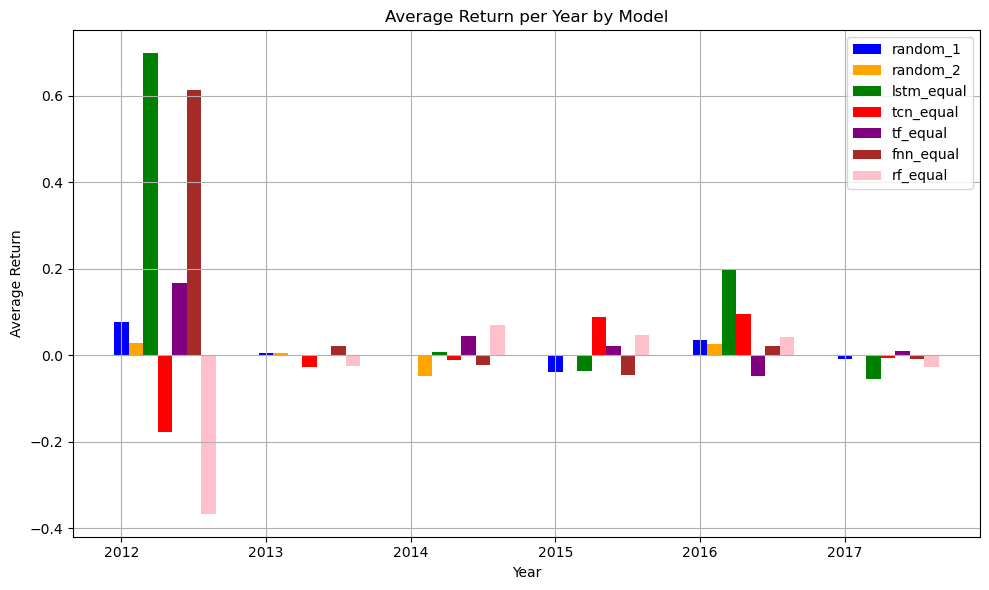

In [247]:
#df = df[df.year >2012]

plt.figure(figsize=(10, 6))
models = ['random_1', 'random_2', 'lstm_equal',  'tcn_equal', 'tf_equal', 'fnn_equal','rf_equal']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
for i, model in enumerate(models):
    plt.bar(df['year'] + i * 0.1, df[model], width=0.1, label=model, color=colors[i])

plt.xlabel('Year')
plt.ylabel('Average Return')
plt.title('Average Return per Year by Model')
plt.legend()
plt.grid(True)
plt.xticks(df['year'])
plt.tight_layout()
plt.show()

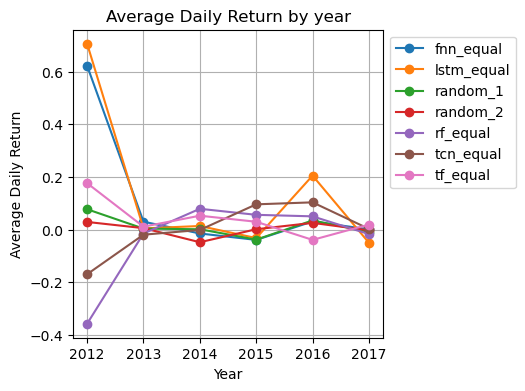

In [217]:
# Average Daily Return by year

plt.figure(figsize=(4,4))

for column in df.columns:
    if column !='year':
        plt.plot(df['year'],df[column],label=column, marker='o')
        
plt.title('Average Daily Return by year')
plt.xlabel('Year')
plt.ylabel('Average Daily Return')
plt.legend(loc='upper left',bbox_to_anchor=(1,1)) 
plt.grid(True)

plt.show()

/tmp/ipykernel_17338/489300399.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (-1)*short_file['daily_return']


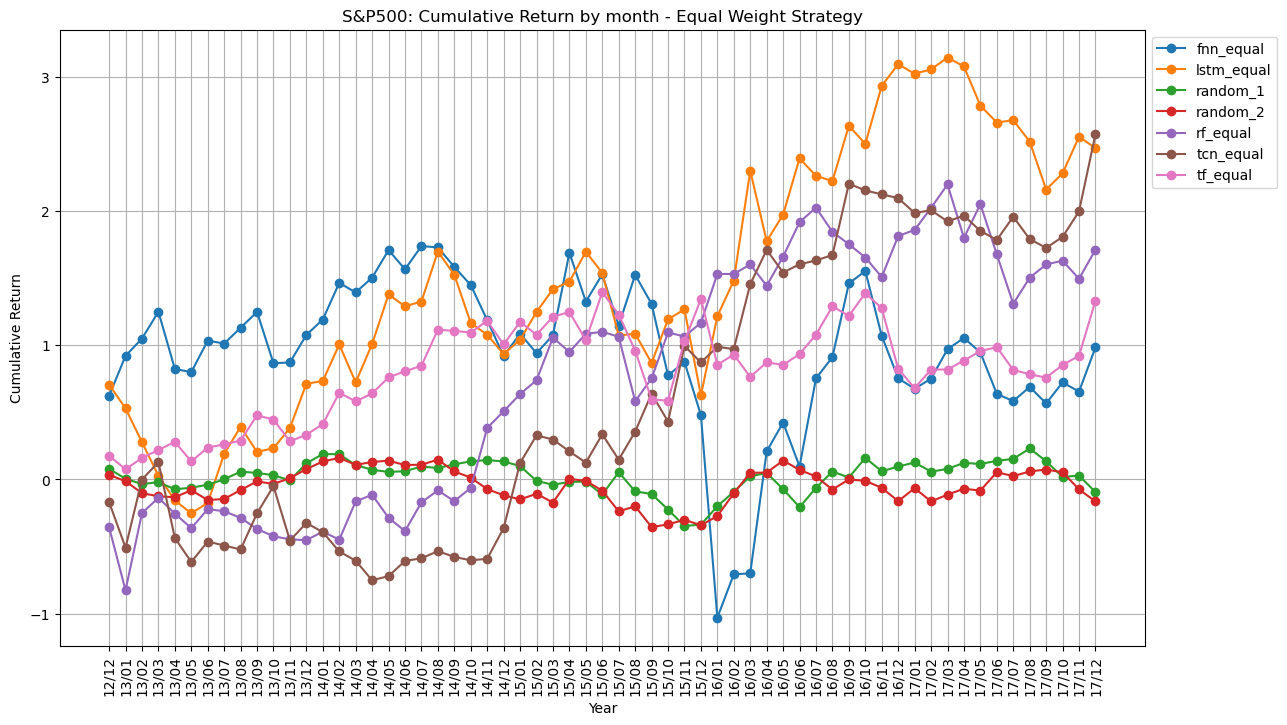

In [205]:
# year month average return

# for each model, read csv and add it to the dataframe
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
              ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv' 
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            , 'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
               , 'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return['date'] =pd.to_datetime(mean_return['date'])
    mean_return['year_month'] = mean_return.date.dt.strftime('%y/%m')
    mean_return['model']=file
    mean_return = mean_return[['model','year_month','daily_return_no_cost']]
    mean_return = mean_return.groupby(['model','year_month'])['daily_return_no_cost'].mean().reset_index()

    summary_return = pd.concat([mean_return,summary_return])


    
#########################
# comparing the performance to market performance

file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-26') & (file['Date']<='2017-12-11')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=10) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=100) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

    
portfolio_performance  = portfolio.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance['model']='random_1'



# Portfolio3
portfolio3 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()
longlist = file['Ticker'].sample(n=10, random_state=0).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=95).to_list()
for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_profit=pd.concat([long_file,long_profit])
for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])

portfolio3 = pd.concat([long_profit, short_profit])    
portfolio_performance3  = portfolio3.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance3.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance3['model']='random_2'



summary_return =pd.concat([summary_return,portfolio_performance,portfolio_performance3])


df2 = summary_return.pivot(index='year_month',columns='model',values='daily_return_no_cost').reset_index()


"""
plt.figure(figsize=(17,8))

for column in df2.columns:
    if column !='year_month':
        plt.plot(df2['year_month'],df2[column],label=column, marker='o')
        
plt.title('Daily Return by month - Equal Weight')
plt.xlabel('Year Month')
plt.xticks(rotation=90)
plt.ylabel('Average Daily Return')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.grid(True)

plt.show()"""


# cum return Prep data
df3 =summary_return.copy()
df3['cum_return']=df3.groupby(['model'])['daily_return_no_cost'].cumsum()
df4 = df3.pivot(index='year_month',columns='model',values='cum_return').reset_index()
df4.dropna(inplace=True)


# cum return by month plot graph

fig  = plt.figure(figsize=(14,8))

for column in df4.columns:
    if column !='year_month':
        plt.plot(df4['year_month'],df4[column],label=column, marker='o')
        
plt.title('S&P500: Cumulative Return by month - Equal Weight Strategy')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=90)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.grid(True)


plt.show()


In [207]:
fig.savefig('sp_equal_weight.png')

/tmp/ipykernel_17338/3857743416.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_file['daily_return'] = (1.3)*long_file['daily_return']
/tmp/ipykernel_17338/3857743416.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']


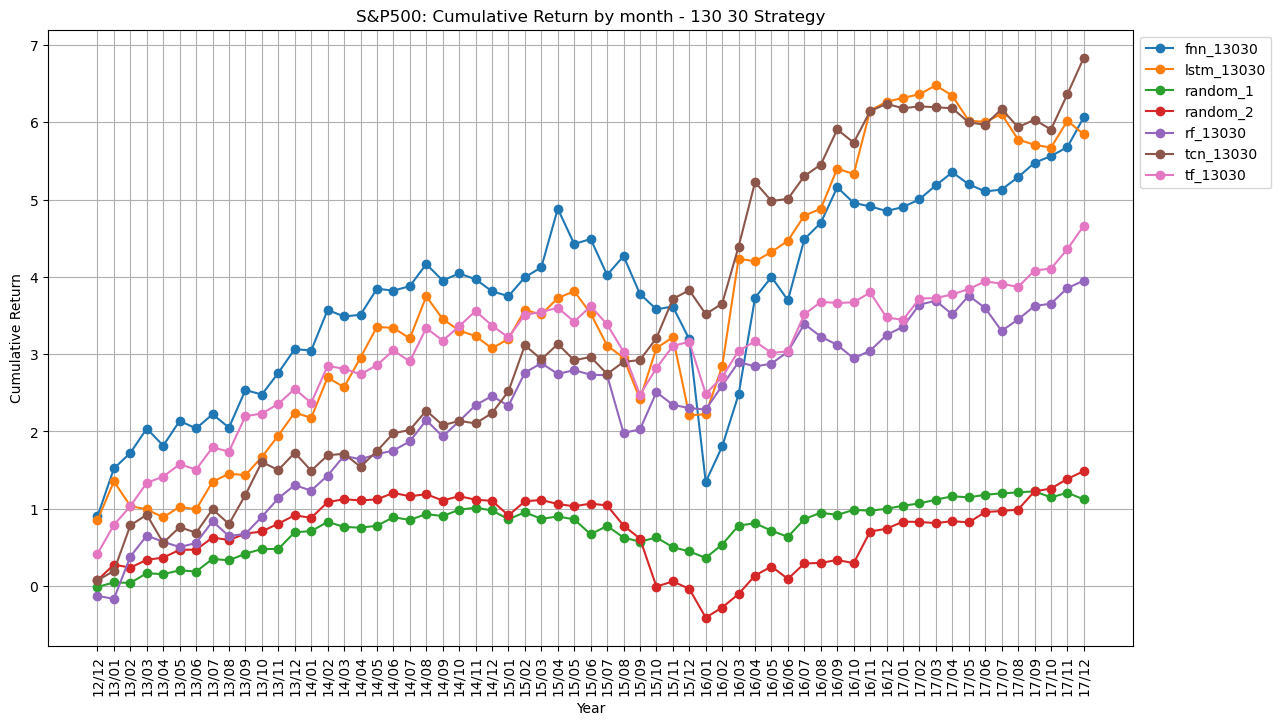

In [208]:
"""    if i < len(unique_dates) - 1:
        next_date = unique_dates[i + 1]
        next_date_file = file[file['Date'] == next_date]
        
        # Select 10 random stocks for long and short positions from the next day's data
        long_file = next_date_file.sample(n=10, random_state=50)
        short_file = next_date_file.sample(n=10, random_state=0)
        
        # Add a column to short stocks to indicate negative returns
        short_file['daily_return'] = (-1) * short_file['daily_return']# 130 30 year month cum return"""

# for each model, read csv and add it to the dataframe
read_csv_dict={
             'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return['date'] =pd.to_datetime(mean_return['date'])
    mean_return['year_month'] = mean_return.date.dt.strftime('%y/%m')
    mean_return['model']=file
    mean_return = mean_return[['model','year_month','daily_return_no_cost']]
    mean_return  = mean_return.groupby(['model','year_month'])['daily_return_no_cost'].mean().reset_index()

    summary_return = pd.concat([mean_return,summary_return])


    
#########################
# comparing the performance to market performance

file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03') & (file['Date']<='2017-12-11')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=10) # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    short_file = date_file.sample(n=10, random_state=100) # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

    
portfolio_performance  = portfolio.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance['model']='random_1'


# Portfolio2
portfolio3 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()

longlist = file['Ticker'].sample(n=10, random_state=0).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=95).to_list()

for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    long_profit=pd.concat([long_file,long_profit])

for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])

portfolio3 = pd.concat([long_profit, short_profit])    

portfolio_performance3  = portfolio3.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance3.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance3['model']='random_2'


summary_return =pd.concat([summary_return,portfolio_performance,portfolio_performance3])
df2 = summary_return.pivot(index='year_month',columns='model',values='daily_return_no_cost').reset_index()


# cum return Prep data
df3 =summary_return.copy()
df3['cum_return']=df3.groupby(['model'])['daily_return_no_cost'].cumsum()
df3 = df3.sort_values(by='model', ascending=True)
df4 = df3.pivot(index='year_month',columns='model',values='cum_return').reset_index()
df4.dropna(inplace=True)

# cum return by month plot graoh

fig  = plt.figure(figsize=(14,8))

for column in df4.columns:
    if column !='year_month':
        plt.plot(df4['year_month'],df4[column],label=column, marker='o')

plt.title('S&P500: Cumulative Return by month - 130 30 Strategy')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=90)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.grid(True)

plt.show()


In [209]:
fig.savefig('sp_130-30.png')

## Portoflio Analysis

In [210]:
# Sharpe Ratio daily
# no cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['excess_return'] = df.daily_return_no_cost -0.003
    #df['std_per_day'] = df.groupby('date')['daily_return_no_cost'].std().reset_index()
    
    
    df = df.sort_values(by='date')
    print("Model :", file)

    # Group by year and calculate total return for each year
    print(df[['daily_return_no_cost']].describe(include =[float]))
    print("=========================================================================")

    

Model : rf_equal
       daily_return_no_cost
count           1249.000000
mean               0.030086
std                0.843161
min               -4.253042
25%               -0.421327
50%               -0.000627
75%                0.479876
max                4.567093
Model : rf_13030
       daily_return_no_cost
count           1249.000000
mean               0.065561
std                1.009657
min               -4.493472
25%               -0.442277
50%                0.092152
75%                0.619204
max                6.907652
Model : fnn_equal
       daily_return_no_cost
count           1249.000000
mean               0.003658
std                1.381457
min               -9.287429
25%               -0.695110
50%                0.000835
75%                0.680601
max                6.711846
Model : fnn_13030
       daily_return_no_cost
count           1249.000000
mean               0.084966
std                1.761345
min               -9.109758
25%               -0.825470
50%   

In [211]:
# annualiezed rate = (1+monthly rate)^12 -1
annual_rf = 1.0217**(12)-1

In [212]:
# annual Sharpe Ratio
# no cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['exces_return'] = df.daily_return_no_cost -0.03
    df = df.sort_values(by='date')

    # Group data by year and calculate standard deviation
    std_per_year = df.groupby('Year')['daily_return_no_cost'].std().reset_index()
    std_per_year.rename(columns={'daily_return_no_cost':'sd'}, inplace=True)

    
    # Group by year and calculate total return for each year
    annual_returns = df.groupby(df['Year'])['daily_return_no_cost'].sum().reset_index()
    annual_returns['excess_return'] =   annual_returns.daily_return_no_cost -annual_rf
    annual_returns = annual_returns.merge(std_per_year, on ='Year')
    annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
    
    print("Model :", file)
    print(annual_returns.mean())
    #print(annual_returns)

    print('=========================')
    

Model : rf_equal
Year                    2014.500000
daily_return_no_cost       6.262978
excess_return              5.969137
sd                         0.798208
sharpe_ratio               7.399149
dtype: float64
Model : rf_13030
Year                    2014.500000
daily_return_no_cost      13.647624
excess_return             13.353783
sd                         0.999020
sharpe_ratio              15.009303
dtype: float64
Model : fnn_equal
Year                    2014.500000
daily_return_no_cost       0.761430
excess_return              0.467590
sd                         1.219522
sharpe_ratio               0.817077
dtype: float64
Model : fnn_13030
Year                    2014.500000
daily_return_no_cost      17.687110
excess_return             17.393270
sd                         1.672152
sharpe_ratio              12.166696
dtype: float64
Model : lstm_equal
Year                    2014.500000
daily_return_no_cost       6.539355
excess_return              6.245515
sd                     

In [213]:
std_per_year

,Year,sd
0,2012,1.117006
1,2013,0.937182
2,2014,0.963614
3,2015,1.262478
4,2016,1.223783
5,2017,0.858598


In [214]:
# Sharpe Ratio daily
# performance characteristic part 3
# with cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['excess_return'] = df.daily_return_cost -0.003
    #df['std_per_day'] = df.groupby('date')['daily_return_no_cost'].std().reset_index()
    
    
    df = df.sort_values(by='date')
    print("Model :", file)

    # Group by year and calculate total return for each year
    print(df[['daily_return_cost']].describe(include =[float]))
    print("=========================================================================")

    

Model : rf_equal
       daily_return_cost
count        1249.000000
mean            0.020767
std             0.843178
min            -4.262542
25%            -0.430327
50%            -0.009210
75%             0.471639
max             4.559093
Model : rf_13030
       daily_return_cost
count        1249.000000
mean            0.058097
std             1.009649
min            -4.500822
25%            -0.449977
50%             0.084152
75%             0.611354
max             6.901252
Model : fnn_equal
       daily_return_cost
count        1249.000000
mean           -0.004920
std             1.381388
min            -9.295929
25%            -0.703610
50%            -0.004716
75%             0.672503
max             6.704846
Model : fnn_13030
       daily_return_cost
count        1249.000000
mean            0.078095
std             1.761256
min            -9.116308
25%            -0.832670
50%             0.107119
75%             0.997378
max            11.338948
Model : lstm_equal
       dail

In [215]:


# annual Sharpe Ratio
# performance characteristic part 4
## with cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['exces_return'] = df.daily_return_no_cost -0.03
    df = df.sort_values(by='date')

    # Group data by year and calculate standard deviation
    std_per_year = df.groupby('Year')['daily_return_cost'].std().reset_index()
    std_per_year.rename(columns={'daily_return_cost':'sd'}, inplace=True)

    
    # Group by year and calculate total return for each year
    annual_returns = df.groupby(df['Year'])['daily_return_cost'].sum().reset_index()
    annual_returns['excess_return'] =   annual_returns.daily_return_cost -annual_rf
    annual_returns = annual_returns.merge(std_per_year, on ='Year')
    annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
    annual_returns
    print("Model :", file)
    print(annual_returns.mean())
    #print(annual_returns)

    print('=========================')
    

Model : rf_equal
Year                 2014.500000
daily_return_cost       4.323061
excess_return           4.029221
sd                      0.798316
sharpe_ratio            4.989498
dtype: float64
Model : rf_13030
Year                 2014.500000
daily_return_cost      12.093899
excess_return          11.800058
sd                      0.999017
sharpe_ratio           13.370887
dtype: float64
Model : fnn_equal
Year                 2014.500000
daily_return_cost      -1.024237
excess_return          -1.318077
sd                      1.219480
sharpe_ratio           -0.637263
dtype: float64
Model : fnn_13030
Year                 2014.500000
daily_return_cost      16.256827
excess_return          15.962986
sd                      1.672151
sharpe_ratio           11.248960
dtype: float64
Model : lstm_equal
Year                 2014.500000
daily_return_cost       5.258438
excess_return           4.964598
sd                      1.369653
sharpe_ratio            2.020644
dtype: float64
Model : lst

## Market Random 

In [ ]:

file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03') & (file['Date']<='2017-12-11')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=10) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=100) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    
    
print(portfolio.daily_return.describe())
print('=========================')

portfolio['date'] =pd.to_datetime(portfolio['Date'])
portfolio['Year'] = portfolio['Date'].dt.year
#portfolio['exces_return'] = portfolio.daily_return -0.03
portfolio = portfolio.sort_values(by='Date')
portfolio

std_per_year = portfolio.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio.groupby(portfolio['Year'])['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']

print('Annaul Return')
print(annual_returns.mean())

print('=========================')

In [184]:
## 130-30 market portfolio

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=10) # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    short_file = date_file.sample(n=10, random_state=100) # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

print(portfolio.daily_return.describe())
print('Portfolio 1 Daily Return: 130-30')
print('=========================')


portfolio['date'] =pd.to_datetime(portfolio['Date'])
portfolio['Year'] = portfolio['Date'].dt.year
portfolio['exces_return'] = portfolio.daily_return -0.03
portfolio = portfolio.sort_values(by='Date')

std_per_year = portfolio.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio.groupby('Year')['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
print('annual return')
print(annual_returns.mean())
print('=========================')

count    25320.000000
mean         0.019374
std          1.594266
min        -24.433796
25%         -0.405138
50%          0.000000
75%          0.451649
max         49.962073
Name: daily_return, dtype: float64
Portfolio 1 Daily Return: 130-30
annual return
Year             2014.500000
daily_return        0.014411
excess_return      -0.279429
sd                  1.520459
sharpe_ratio       -0.188201
dtype: float64


In [185]:
# Portfolio2 equal weight


file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03')  & (file['Date']<='2017-12-11')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')


portfolio3 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()
longlist = file['Ticker'].sample(n=10, random_state=0).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=95).to_list()
for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_profit=pd.concat([long_file,long_profit])
for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])
portfolio3 = pd.concat([long_profit, short_profit])    

print(portfolio3[['daily_return']].describe(include =[float]))

print('=========================')
portfolio3['date'] =pd.to_datetime(portfolio3['Date'])
portfolio3['Year'] = portfolio3['Date'].dt.year
portfolio3['exces_return'] = portfolio3.daily_return -0.03
portfolio3 = portfolio3.sort_values(by='Date')
portfolio3

std_per_year = portfolio3.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio3.groupby(portfolio3['Year'])['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
print('Annual Return')
print(annual_returns.mean())

print('=========================')

/tmp/ipykernel_17338/1818056589.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (-1)*short_file['daily_return']


       daily_return
count  24342.000000
mean      -0.039147
std        1.632480
min      -42.223513
25%       -0.718904
50%       -0.068766
75%        0.732886
max       22.838909
Annual Return
Year             2014.500000
daily_return       -0.025461
excess_return      -0.319301
sd                  1.604812
sharpe_ratio       -0.200202
dtype: float64


In [187]:
# Portfolio2 130-30 weight


file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03')  & (file['Date']<='2017-12-11')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')


portfolio3 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()
longlist = file['Ticker'].sample(n=10, random_state=0).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=95).to_list()
for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    long_profit=pd.concat([long_file,long_profit])

for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])

portfolio3 = pd.concat([long_profit, short_profit])    

print(portfolio3[['daily_return']].describe(include =[float]))

print('=========================')
portfolio3['date'] =pd.to_datetime(portfolio3['Date'])
portfolio3['Year'] = portfolio3['Date'].dt.year
portfolio3['exces_return'] = portfolio3.daily_return -0.03
portfolio3 = portfolio3.sort_values(by='Date')
portfolio3

std_per_year = portfolio3.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio3.groupby(portfolio3['Year'])['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
print('Annual Return')
print(annual_returns.mean())

print('=========================')

/tmp/ipykernel_17338/1907894111.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_file['daily_return'] = (1.3)*long_file['daily_return']
/tmp/ipykernel_17338/1907894111.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']


       daily_return
count  24342.000000
mean      -0.013212
std        1.534728
min      -21.630135
25%       -0.581035
50%       -0.030739
75%        0.444578
max       29.690582
Annual Return
Year             2014.500000
daily_return        0.012008
excess_return      -0.281833
sd                  1.456108
sharpe_ratio       -0.194735
dtype: float64


In [96]:
# Data for S&P 500
sp500_data = {
    'Model': ['LSTM', 'TCN', 'Transformer', 'FNN', 'RF'],
    'k=5': [0.516, 0.508, 0.501, 0.505, 0.517],
    'k=10': [0.515, 0.507, 0.503, 0.503, 0.511],
    'k=50': [0.515, 0.503, 0.502, 0.503, 0.502],
    'k=100': [0.51, 0.503, 0.502, 0.502, 0.501],
    'k=150': [0.507, 0.503, 0.502, 0.502, 0.501],
    'k=200': [0.506, 0.503, 0.502, 0.502, 0.501]
}

# Create dataframe
sp500_df = pd.DataFrame(sp500_data)
sp500_df = sp500_df.set_index('Model').T.reset_index()
sp500_df.set_index('index', inplace=True)
sp500_df

Model,index,LSTM,TCN,Transformer,FNN,RF
0,k=5,0.516,0.508,0.501,0.505,0.517
1,k=10,0.515,0.507,0.503,0.503,0.511
2,k=50,0.515,0.503,0.502,0.503,0.502
3,k=100,0.510,0.503,0.502,0.502,0.501
4,k=150,0.507,0.503,0.502,0.502,0.501
5,k=200,0.506,0.503,0.502,0.502,0.501


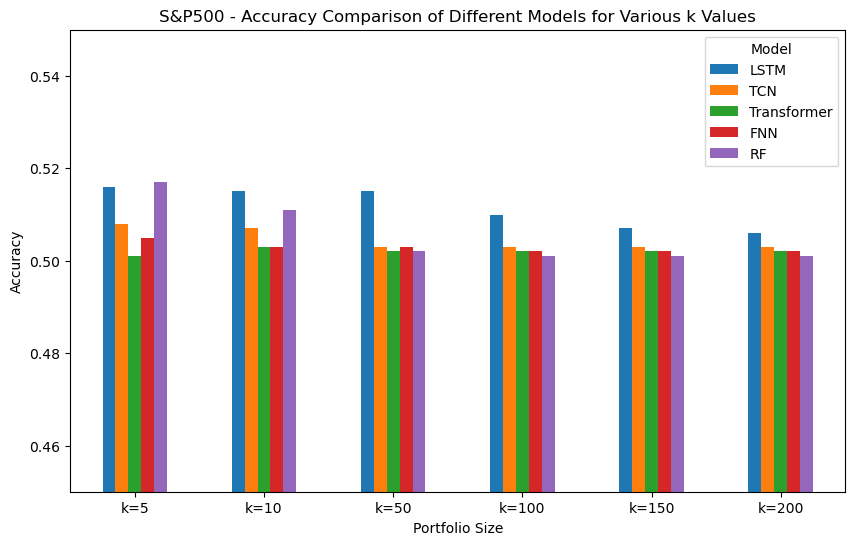

In [115]:
# Plotting
ax = sp500_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.xlabel('Portfolio Size')
plt.ylabel('Accuracy')
plt.title('S&P500 - Accuracy Comparison of Different Models for Various k Values')
plt.legend(title='Model')
plt.ylim(0.45,0.55)

plt.savefig('S&Paccuracy.png')

plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# test out different trading strategy

# cum return 

# for each model, read csv and add it to the dataframe
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'rf_long': 'rf_prediction_daily_return_summary_longonly.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'fnn_long': 'fnn_prediction_daily_return_summary_longonly.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'lstm_long': 'lstm_prediction_daily_return_summary_longonly.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tcn_long': 'tcn_prediction_daily_return_summary_longonly.csv'
            #,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            #,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
            #,'tf_long': 'tf_prediction_daily_return_summary_longonly.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return = mean_return[mean_return['date']==max(mean_return['date'])]
    mean_return['model']=file
    mean_return = mean_return[['model','cum_return_no_cost']]
    summary_return = pd.concat([mean_return,summary_return])

#### random portofolio
file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-26') ]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=10) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=100) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

portfolio_performance = portfolio.groupby(['Date'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'cum_return_no_cost'},inplace=True)
portfolio_performance = portfolio_performance['cum_return_no_cost'].cumsum().reset_index()
portfolio_performance['model']='random_1'
portfolio_performance = portfolio_performance[-1:]
portfolio_performance = portfolio_performance[['model','cum_return_no_cost']]


# Porfolio 2
portfolio2 = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=95) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio2 = pd.concat([portfolio2,long_file, short_file])    

portfolio_performance2  = portfolio2.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance2.rename(columns={'daily_return':'cum_return_no_cost'},inplace=True)
portfolio_performance2 = portfolio_performance['cum_return_no_cost'].cumsum().reset_index()
portfolio_performance2['model']='random_2'
portfolio_performance2 = portfolio_performance2[-1:]
portfolio_performance2 = portfolio_performance2[['model','cum_return_no_cost']]

summary_return =pd.concat([portfolio_performance, portfolio_performance2,summary_return])


plt.figure(figsize=(15,8))

#for column in df.columns:
#    plt.plot(summary_return[column],summary_return['cum_return_no_cost'])

color_label=['purple','purple','blue','blue','blue','green','green','green','yellow','yellow','yellow'
             ,'orange','orange','orange'
            ]

plt.bar(summary_return['model'],summary_return['cum_return_no_cost'],color=color_label)
plt.title('Cumulative Mean Return by trading strategy')
plt.xlabel('Year')
plt.ylabel('Cumulative Mean Return')
plt.tight_layout()

plt.show()

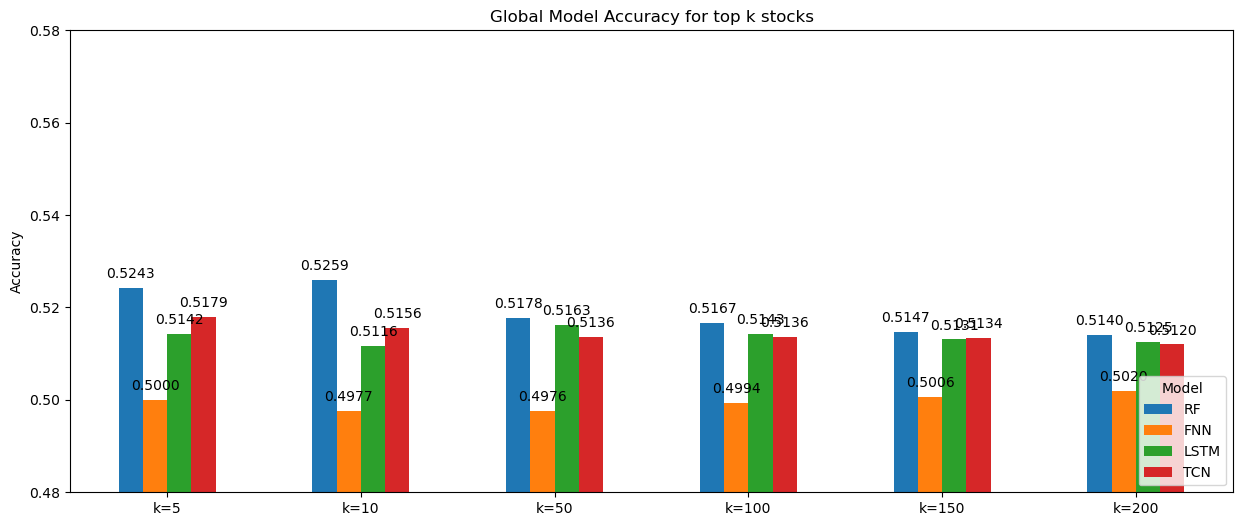

In [60]:
# Accuracy Plotting


import pandas as pd
import matplotlib.pyplot as plt

# for all data 
# RF, FNN, LSTM, TCN, Transformer
d={'k=5':[0.5243, 0.5,0.5142,0.5179],'k=10':[0.5259, 0.4977, 0.5116,0.5156], 'k=50':[0.5178, 0.4976,0.5163,0.5136]
   , 'k=100':[0.5167, 0.4994, 0.5143,0.5136],'k=150':[0.5147,0.5006,0.5131,0.5134],'k=200':[0.514, 0.502,0.5125,0.512]}
  

accuracy = pd.DataFrame(data=d ,index=['RF', 'FNN','LSTM','TCN'])
accuracy


accuracy_T = accuracy.T


ax = accuracy_T.plot(kind='bar', rot=0, figsize=(15, 6))
plt.title('Global Model Accuracy for top k stocks')
#plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.legend(title='Model', loc='lower right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylim(0.48, 0.58)    
plt.show()

